# Spectral clustering tunning

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score

from clust_functions import plot, get_size, silhouette_plot
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

RAND = 10

In [7]:
# загрузка эмбеддингов после UMAP (3 измерения)
X_embedding = pd.read_pickle('X_embedding_3.pkl')
X_embedding.head()

,0,1,2
0,-3.099881,-2.076641,4.294221
1,-2.878557,-0.563933,3.511552
2,-0.888033,4.634923,-1.450897
3,4.990706,8.355982,-3.858088
4,8.829126,7.900076,-3.438453


## Гиперпараметры spectral clustering 

Повышать качество baseline модели будем с помощью подбора следующих гиперпараметров. Определим три группы параметров по их роли в работе алгоритма. Начнём настраивать алгоритм, беря параметры с конца в последовательности его работы.

Группа 1 (группировка по кластерам)
- n_clusters # количество кластеров
- assign_labels {kmeans, discretize}, (default=kmeans) # финальный алгоритм кластеризации

Группа 2 (вычисление собственных векторов и значений Лаплассиана)
- eigen_solver {arpack, lobpcg, amg}, (default = None) # стратегии разложения Лаплассиана

Группа 3 (построение матрицы смежности)
- affinity {nearest_neighbors, rbf, pairwise_kernels}, (default = rbf) # метод построения матрицы
- n_neighbors (для affinity = nearest_neighbors), (default = 10) 

###  Количество кластеров

Оптимальное количество кластеров будем искать с помощью оценки по методу логтя метрик количества объектов в кластерах. А также по оценке силуэтного коэффициента и индекса Калински Харабаша.

По дефолту в моделе установлено n_clusters = 8 (средний силуэт = 0.554), для n_clusters = 28 (по следам автоопределения количества кластеров в DBSCAN) средний силуэт = 0.552.

В идеале, 8 кластеров на 1700 объектов многовато для оперативной обработки результатов кластеризации. Посмотрим, можно ли добиться большего показателя метрик для n_clusters > 8.

Используемые метрики:
- силуэтный коэффициент - отношение растояния между объектами внутри кластера к растоянию до объектов другого кластера. Варьируентся в диапазоне [-1; 1], максимизируем.
- индекс Калински Харабаша - отношение суммы дисперсии между кластерами и дисперсии внутри кластера. Более высокое значение CH  означает, что точки данных более распределены между кластерами, чем внутри кластеров.

In [8]:
def calculate_optimal_distance(clust_list: list , list_score: list )-> int:
    """
    Поиск наибольшего расстояния для метода локтя
    
    clust_list - количество кластеров для перебора
    list_score - значения метрики для каждого n_clusters
    """
    
    x1, y1 = clust_list[0], clust_list[0]
    x2, y2 = clust_list[-1], clust_list[-1]
    A, B, C = y1 - y2, x2 - x1, x1 * y2 - x2 * y1

    max_dist = -np.inf
    max_x = -np.inf
    for num, i in enumerate(list_score[1:-1]):
        x_0, y_0 = clust_list[num], list_score[num]
        dist = abs(A * x_0 + B * y_0 + C) / np.sqrt(A**2 + B**2)

        if dist > max_dist:
            max_dist = dist
            max_x = x_0
        else:
            continue
            
    return max_dist, max_x



In [9]:
def elbow_plot(labels_std: list,
                  labels_min: list,
                  labels_max: list,
                  labels_median: list,
                  type_optimal: list,
                  clust_list: list)-> None:
    """
    Метод локтя

    Функция для вывода графика зависимостей стандартной ошибки, 
    минимального и максимального числа объектов от кол-ва кластеров
    
    labels_std - набор std для кластеров
    labels_min - min кол-во объектов в кластерах
    labels_max - max кол-во объектов в кластерах
    labels_median - среднее кол-во объектов в кластерах
    clust_list - количество кластеров для перебора
    """

    _, opt_cluster = calculate_optimal_distance(
        clust_list, type_optimal)

    plt.figure(figsize=(8, 6))
    plt.plot(clust_list, labels_std,
             marker='s', color='green', label='std')
    plt.plot(clust_list, labels_min,
             marker='s', color='grey', linestyle='dashed', label='min')
    plt.plot(clust_list, labels_median,
             marker='o', color='skyblue', linestyle='dashed', label='median')
    plt.plot(clust_list, labels_max,
             marker='o', color='grey',  linestyle='dashed', label='max')
    plt.xlabel('Кластер')
    plt.ylabel('Станд.ошибка / Мин.кластер / Median / Макс.кластер')
    plt.axvline(x=opt_cluster, color='black',
                label=f'optimal clust= {opt_cluster}', linestyle='dashed')
    plt.legend()
    plt.show()
    
    return



In [31]:
def metric_plot(score_list: list, clust_list: list,
                   name_metric: str)-> None:
    """
    Функция для вывода графика зависимости метрики от кол-ва кластеров
    
    score_list - значения метрики для каждого n_clusters
    clust_list - количество кластеров для перебора
    name_metric - метрика  
    """
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(clust_list, score_list, marker='s')
    plt.xlabel('$Clusters$')
    plt.ylabel(f'${name_metric}$')
    plt.show()
    
    return



In [32]:
# пустые списки для метрик Калински Харабаша и силуэтного коэффициента
calinski_harabasz = []
silhouette_list = []

# пустые списки для максимального, минимального и среднего количества объектов в кластерах и std
labels_std = []
labels_min = []
labels_median = []
labels_max = []

### Итерация подбора 1: от 2 до 10 кластеров 

In [51]:
def clusters_number_plots(min_clust: int, 
                          max_clust: int,
                          step: int)-> None:
    """
    Функция для вывода графиков по методу логтя 
    и записимостей индекса CH и силуэта от количетва кластеров
    
    min_clust - нижний предел количества кластеров
    max_clust - вершний предел количества кластеров
    """

    # очистка списков
    calinski_harabasz.clear() 
    silhouette_list.clear() 

    labels_std.clear() 
    labels_min.clear() 
    labels_median.clear() 
    labels_max.clear() 
    
    # в цикле от min_clust до max_clust кластеров
    list_k = list(range(min_clust, max_clust+1, step))
    
    for clust in tqdm_notebook(list_k):
        sp_clust = SpectralClustering(n_clusters=clust)
        sp_clust.fit(X_embedding) 
    
        # calinski_harabasz
        calinski_harabasz.append(calinski_harabasz_score(X_embedding, sp_clust.labels_))
        # silhouette
        silhouette_list.append(silhouette_score(X_embedding, sp_clust.labels_, metric='cosine'))
    
        _, counts = np.unique(sp_clust.labels_, return_counts=True)
     
        # std, min, max, median
        labels_std.append(np.std(counts))
        labels_min.append(np.min(counts))
        labels_max.append(np.max(counts))
        labels_median.append(np.median(counts))
        
    # метод логтя для количества объектов в кластерах
    elbow_plot(labels_std, labels_min, labels_max,
              labels_median, labels_median, list_k)
    
    # постоение изменения индекса Калински Харабаша и силуэтного коэффициента от числа кластеров
    metric_plot(calinski_harabasz, list_k, 
               name_metric='Calinski harabasz')
    metric_plot(silhouette_list, list_k,
               name_metric='Silhouette')
    return



  0%|          | 0/5 [00:00<?, ?it/s]

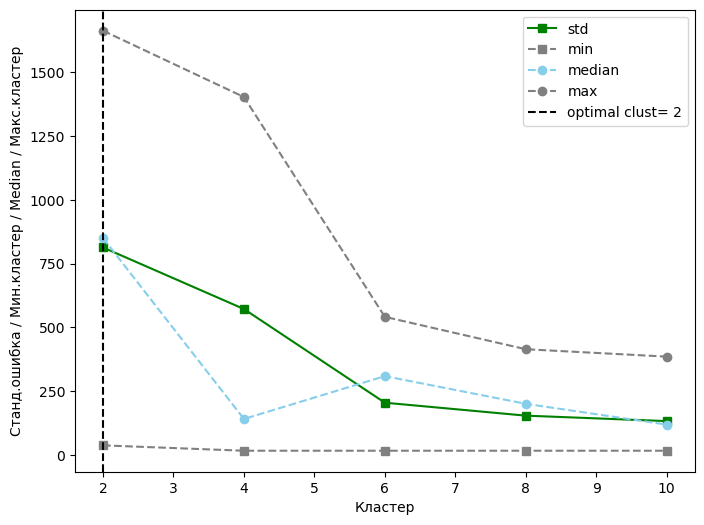

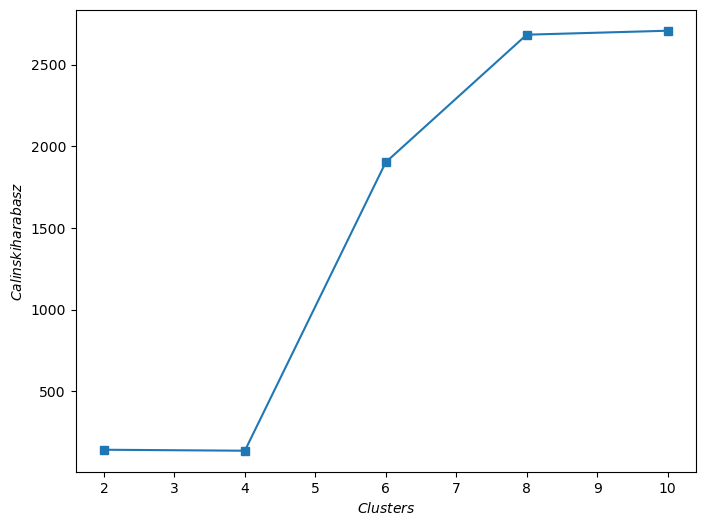

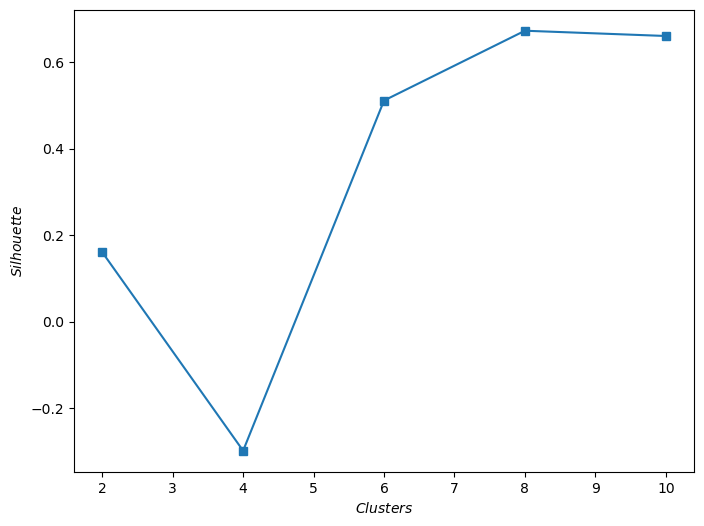

In [30]:
# в цикле от 2 до 10 кластеров
clusters_number_plots(2, 10, 2)

<div class="alert alert-block alert-info">
 
По методу логтя при оценке равномерной заполненности кластеров определено оптимальное n_clusters = 2.

</div>

<div class="alert alert-block alert-info">
Наибольший индекс Калински Харабаша достигается для 10 кластеров. По распределению силуэтного коэффициента, оптимальное значение n_clusters=8. Так как разница в инжексе Калински Харабаша для n_clusters = 8 и = 10 несущественна, принимаем оптимальное (для данной итерации) n_clusters = 8.
    
</div>

### Итерация подбора 2: от 8 до 40 кластеров 

  0%|          | 0/17 [00:00<?, ?it/s]

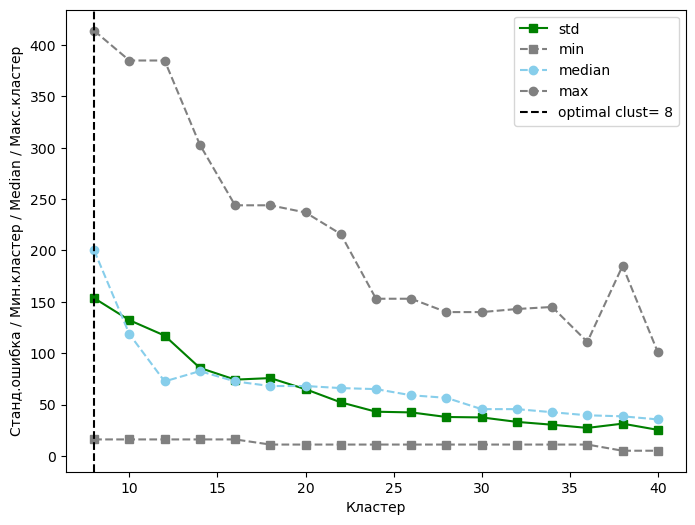

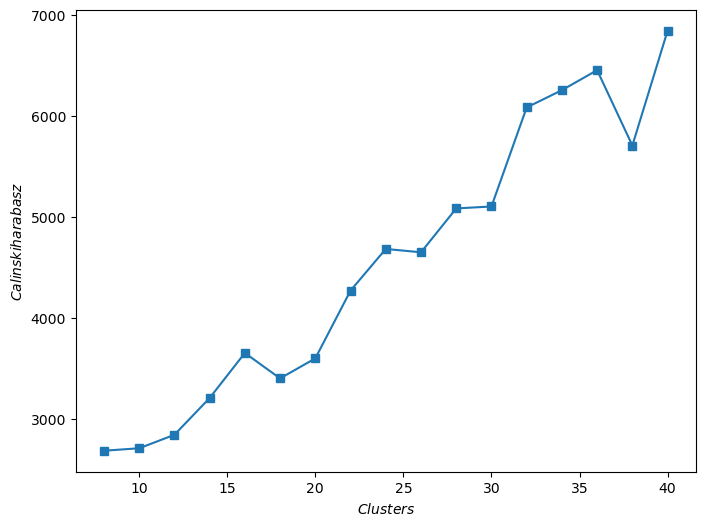

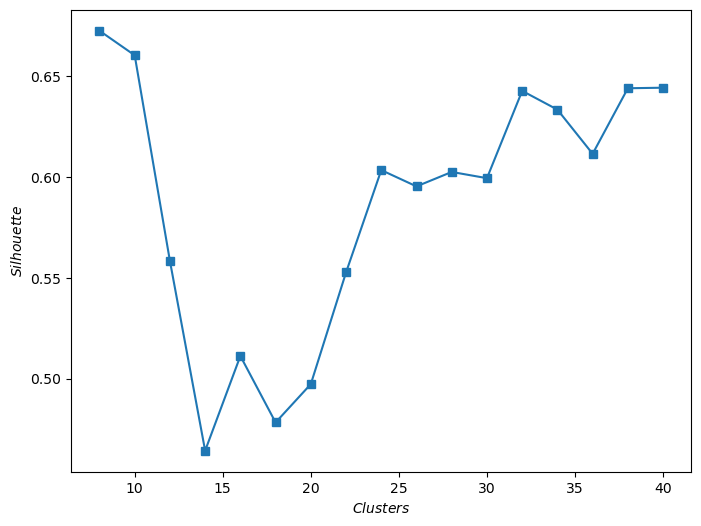

In [39]:
# в цикле от 8 до 40 кластеров
clusters_number_plots(8, 40, 2)

<div class="alert alert-block alert-info">
По методу логтя оптимальное количество кластеров = 8.

</div>

<div class="alert alert-block alert-info">
Наибольший индекс Калински Харабаша достигается для 40 кластеров. По распределению силуэтного коэффициента, до n_clusters=18 значение метрики падает, далее возрастает и, начиная с n_clusters=48 выходит на плато.
    
**На данной итерации принимаем оптимальное n_clusters = 40.**

</div>

### Итерация подбора 3: от 10 до 70 кластеров 

  0%|          | 0/7 [00:00<?, ?it/s]

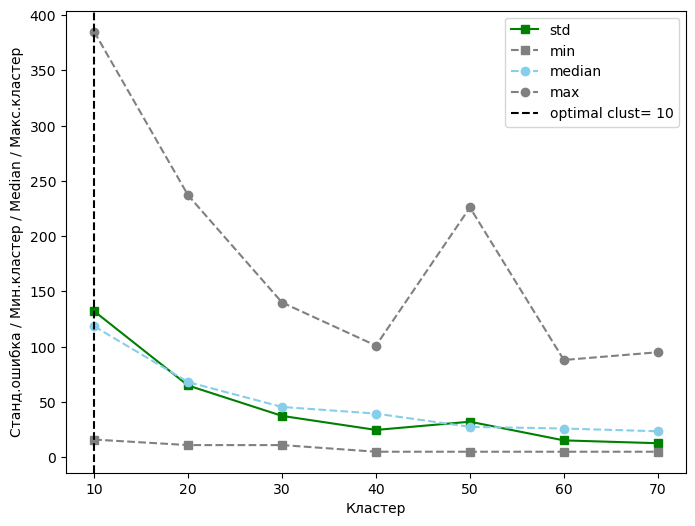

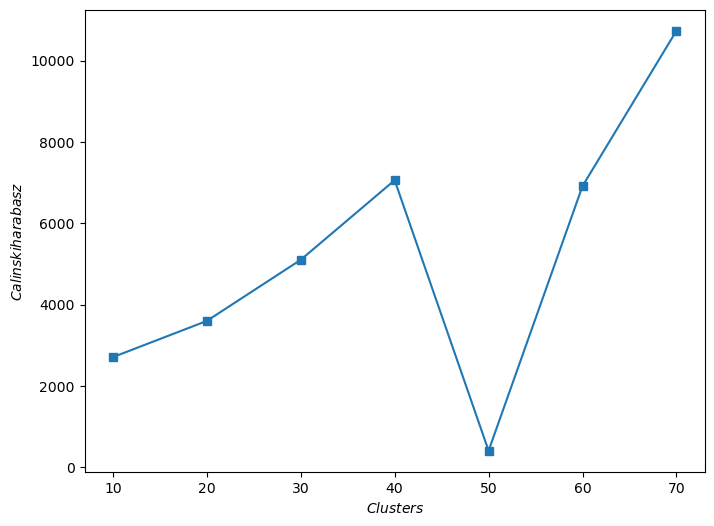

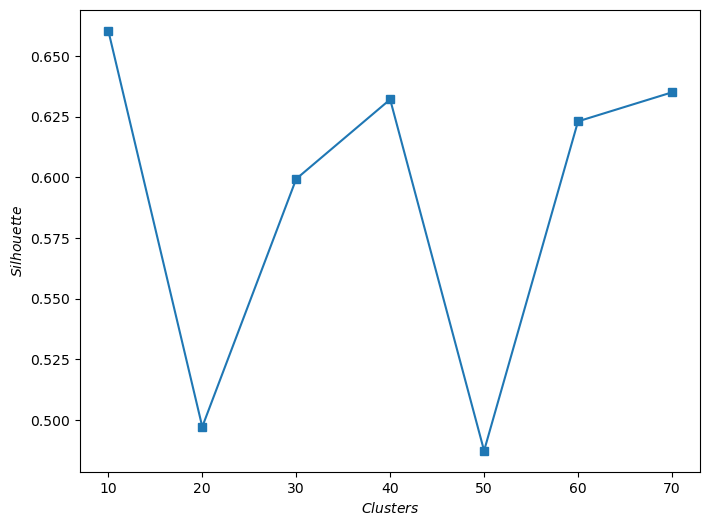

In [52]:
# в цикле от 40 до 70 кластеров
clusters_number_plots(10, 70, 10)

<div class="alert alert-block alert-info">
По методу логтя оптимальное количество кластеров = 10.

</div>

<div class="alert alert-block alert-info">
Индекс Калински Харабаша максимален при n_clusters = 70, однако локальный максимум также достигается при n_clusters = 40.
    
Максимальный силуэтный коэффициент достигается при n_clusters = 40.
    
**Оптимальное n_clusters = 40.**

</div>

### Итерация подбора 4: между n_clusters = 8, 40

  0%|          | 0/2 [00:00<?, ?it/s]

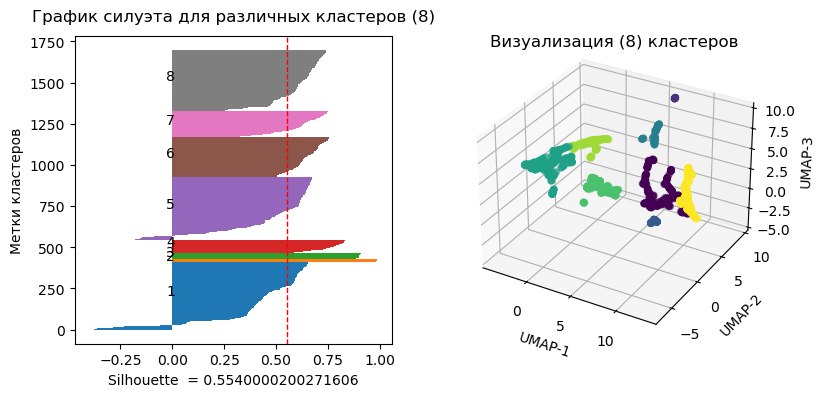

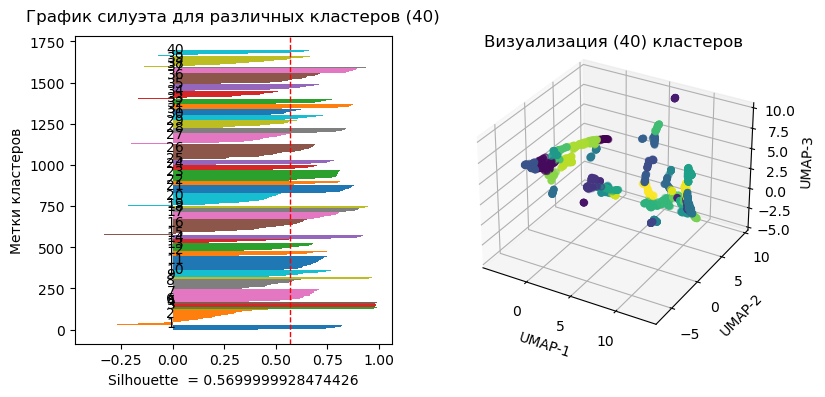

In [53]:
# для выбора оптимумма среди n_clusters = [8, 40], отобразим силуэтный коэффициент по кластерам
for k in tqdm_notebook([8, 40]):
    
    clf = SpectralClustering(n_clusters=k)
    clf.fit(X_embedding)
    
    fig = plt.figure(figsize=[9, 4])
    
    ax = fig.add_subplot(1, 2, 1)
    # Построение графика силуэтного скора
    silhouette_plot(X_embedding, clf.labels_, ax=ax)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    plot(X_embedding, clf.labels_, ax=ax)

<div class="alert alert-block alert-info">

Выбираем n_clusters = 40, так как в этом случае средний силуэт выше и отрицательное значение силуэтного коэффициента минимально. 

</div>

###  Метод назначения меток

Гиперпараметр assign_labels {kmeans, discretize}, (default=kmeans)

Из документации sklearn:
k-means - популярный выбор, но он может быть чувствителен к инициализации; discretize - менее чувствителен к случайной инициализации.

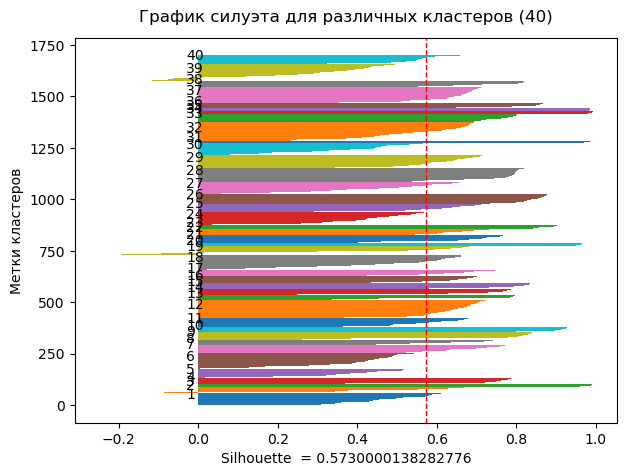

In [54]:
sc_40_disc = SpectralClustering(n_clusters=40, assign_labels='discretize')
sc_40_disc.fit(X_embedding)

silhouette_plot(X_embedding, sc_40_disc.labels_)

<div class="alert alert-block alert-info">

При задании assign_labels='discretize' средний силуэтный коэффициент увеличился (был = 0.569, стал = 0.573). Оставляем assign_labels = discretize.

</div>

###  Метод вычисления собственных векторов и значений Лаплассиана

eigen_solver {arpack, lobpcg}, (default = None) 

- ARPACK: Метод Арнольди - строит ортогональный базис подпространства Крылова, порождённого матрицей и начальным вектором, а затем проецирует исходную собственную задачу на это подпространство


- LOBPCG: реализует локально-оптимальный градиент для нахождения нескольких наименьших по модулю собственных значений и собственных векторов матрицы. 



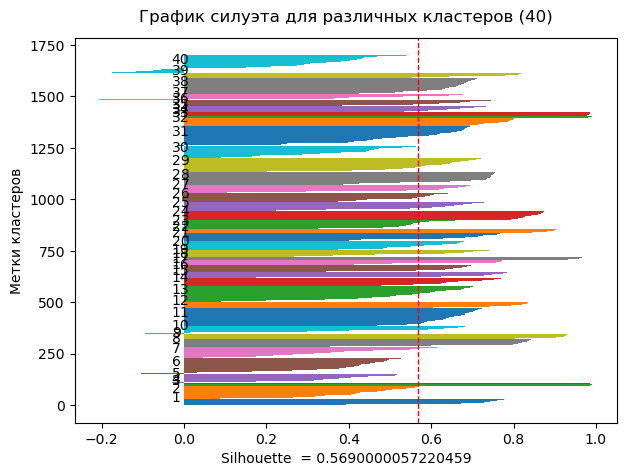

In [55]:
sc_40_arpack = SpectralClustering(n_clusters=40, assign_labels='discretize', eigen_solver='arpack')
sc_40_arpack.fit(X_embedding)

silhouette_plot(X_embedding, sc_40_arpack.labels_)

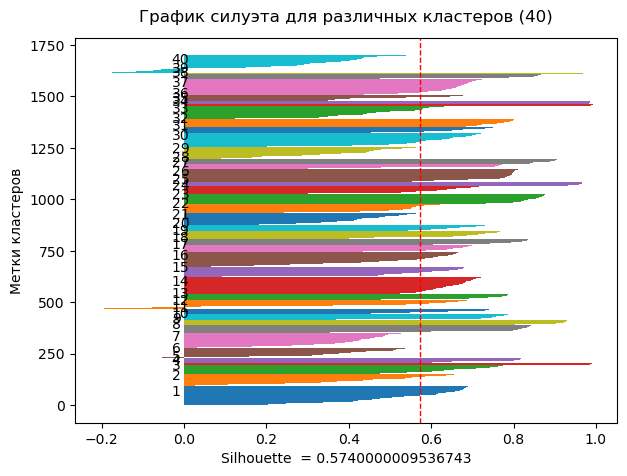

In [56]:
sc_40_lobpcg = SpectralClustering(n_clusters=40, assign_labels='discretize', eigen_solver='lobpcg')
sc_40_lobpcg.fit(X_embedding)

silhouette_plot(X_embedding, sc_40_lobpcg.labels_)

<div class="alert alert-block alert-info">

При задании eigen_solver='lobpcg' средний силуэтный коэффициент повысился (был = 0.573, стал = 0.574). Далее будем задавать eigen_solver='lobpcg'.

</div>

###  Метод построения матрицы смежности

affinity {nearest_neighbors, rbf}, (default = rbf) # метод построения матрицы
n_neighbors - количество соседей для affinity = nearest_neighbors

In [57]:
ch = []
silhouette = []
list_n = [10, 20, 30, 40, 50]

In [58]:
for n in list_n:
    
    clf = SpectralClustering(n_clusters=40, assign_labels='discretize', eigen_solver='lobpcg', 
                             affinity='nearest_neighbors', n_neighbors=n)
    clf.fit(X_embedding)
    
    # calinski_harabasz
    ch.append(calinski_harabasz_score(X_embedding, clf.labels_))
    # silhouette
    silhouette.append(silhouette_score(X_embedding, clf.labels_))

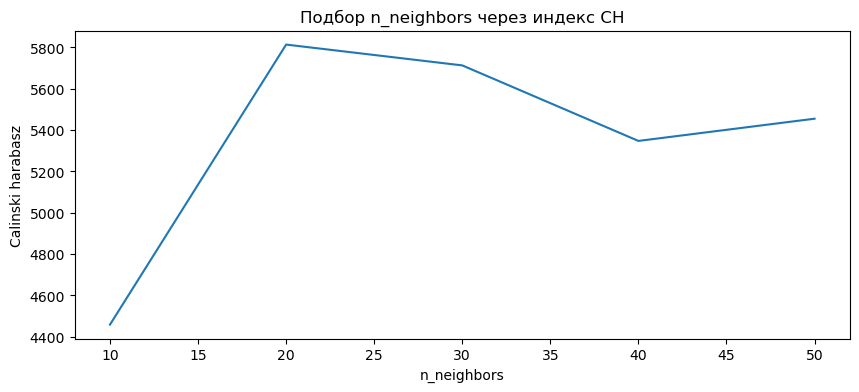

In [59]:
plt.figure(figsize=(10, 4))
plt.plot(list_n, ch)
plt.xlabel("n_neighbors")
plt.ylabel("Calinski harabasz")
plt.title('Подбор n_neighbors через индекс CH')

plt.show()

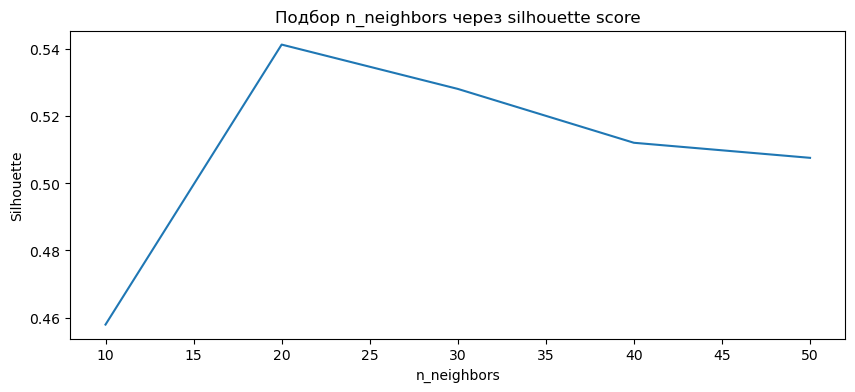

In [60]:
plt.figure(figsize=(10, 4))
plt.plot(list_n, silhouette)
plt.xlabel("n_neighbors")
plt.ylabel("Silhouette")
plt.title('Подбор n_neighbors через silhouette score')

plt.show()

<div class="alert alert-block alert-info">

Наилучшие значения достигаются при n_neighbors = 20. Однако значение силуэтного коэффициента < 0.54, значит изменение параметра affinity='nearest_neighbors' не улучшает модель
</div>

## Выводы 

Для Spectral clustering были подобраны гиперпараметры, дающие наилучшее качество модели:


**SpectralClustering(n_clusters=40, assign_labels='discretize', eigen_solver='lobpcg', affinity='rbf')**

Для данного алгоритма достигается равномерная заполненность кластеров (max_objects = 140, min_objects = 20). Индекс Калински Харабаша максимален > 8000. Средний силуэтный коэффиент максимален = 0.574. Средний силуэтный коэффициент показывает достаточную степень уверенности в кластеризации.

По методу логтя было определено оптимальное количество кластеров = 8. Хотя средний силуэтный коэффициент не сильно уступает модели с n_clusters=40 (Silhouette = 0.554), но для практического применения такое малое количество кластеров непременимо. Потому что тестировщик должен за 1 рабочий день просмотреть все тесты из схожей группы, что очень большая нагрузка при разбиении на массивные кластеры.


